# **MNIST: Sklearn and Keras** 
**Comparing the performance of ML and DL classification models on**  
**the Digit Recognizer (MNIST) competition**  


*from Kaggle:*   
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision.  
In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

**My first kernel for the MNIST Digit Recognizer Competition**  

The kernel includes an **EDA part** on the distribution of labels and some sample images for each digit.  
We explore how the images of handwritten digits are stored as 784 values (pixels).  
We transform these 784 pixels back to images of 28 x 28 (width x heigth) and have a look at possible difficulties in identifying and distinguishing certain digits.  
The part on **prediction modelling** starts with **classifiers from sklearn**:  
Perceptron, Logistic Regression, Random Forest, SVM, Multi Layer Perceptron  
and then continues to **Neural Networks with Keras**:   
Dense (1,2 and 3 layers) and CNN (Conv2D, MaxPooling, Dropout)

**Outline of the kernel:**

**Part 0: Imports, functions**

[some useful functions](#some-useful-functions)


**Part 1: Exploring the Data**

[Distribution of labels](#Distribution-of-labels)  
[first 10 samples for each digit](#first-10-image-samples-for-each-digit)  
[Conclusions on EDA](#Conclusions-on-EDA) 


**Part 2: Sklearn Classifiers** 

[Perceptron](#Perceptron)  
[Logistic Regression](#Logistic-Regression)  
[KNN](#KNN)  
[Random Forest Classifier](#Random-Forest-Classifier)  
[Support Vector Machine Classifier](#Support-Vector-Machine-Classifier)  
[Multi Layer Perceptron](#Multi-Layer-Perceptron)


**Part 3: NN and CNN Classifiers with Keras**

3.1 Fully-Connected Neural Networks  
[Keras: dense, 1 hidden layer](#Keras:-1-hidden-layer)  
[Keras: dense, 2 hidden layers](#Keras:-2-hidden-layers)  
[Keras: dense, 3 hidden layers](#Keras:-3-hidden-layers)  
3.2 Convolutional Neural Networks, CNN  
[features : reshaping 1d vector to 2d images](#features-:-reshaping-1d-vector-to-2d-images)  
[Keras: CNN, model 1](#Keras:-CNN-model-1)  
[Keras: CNN, model 2](#Keras:-CNN-model-2)

**Part 4: Predictions for test data**  
[Fitting on all training data](#Fitting-on-all-training-data)  

**Part 5: Comparing classifier performance**  
[Validation scores](#Validation-scores)  
[Test scores](#Test-scores)  


**Part 6: Different optimizers**  
rmsprop  
adam  

**to be continued**


# Part 0: Imports, Functions

In [1]:
import numpy as np 
import pandas as pd 

import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# plotly library
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import itertools

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
#from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

import os
print(os.listdir("../input"))


Using TensorFlow backend.


['test.csv', 'train.csv', 'sample_submission.csv']


**some global variables**

In [2]:
img_rows, img_cols = 28, 28

np.random.seed(5)
#rn.seed(5)
#tf.set_random_seed(5)

### **some useful functions**

### get_best_score for GridSearchCV

In [3]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

### print Classification Report and Accuracy

In [4]:
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

### plot_confusion_matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### plot_history_loss_and_acc

In [6]:
def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_keras_nn.history['acc'])
    axs[1].plot(history_keras_nn.history['val_acc'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

### **Reading the data**

In [7]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [8]:
y = train["label"]
X = train.drop(["label"],axis = 1)
X_test = test

### Normalization

In [9]:
X = X/255.0
X_test = X_test/255.0

### setting train and validation data

In [10]:
# for best performance, especially of the NN classfiers,
# set mode = "commit"
mode = "edit"
mode = "commit"
#

if mode == "edit" :
    nr_samples = 1200

if mode == "commit" :    
    nr_samples = 30000

y_train=y[:nr_samples]
X_train=X[:nr_samples]
start_ix_val = nr_samples 
end_ix_val = nr_samples + int(nr_samples/3)
y_val=y[start_ix_val:end_ix_val]
X_val=X[start_ix_val:end_ix_val]
    
print("nr_samples train data:", nr_samples)
print("start_ix_val:", start_ix_val)
print("end_ix_val:", end_ix_val)

nr_samples train data: 30000
start_ix_val: 30000
end_ix_val: 40000


# Part 1 : Exploring the Data

In [11]:
print("X:")
print(X.info())
print("*"*50)
print("X_test:")
print(X_test.info())
print("*"*50)
print("y:")
print(y.shape)

X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 251.2 MB
None
**************************************************
X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 167.5 MB
None
**************************************************
y:
(42000,)


In [12]:
X.iloc[0:5,:]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y.iloc[0:5]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

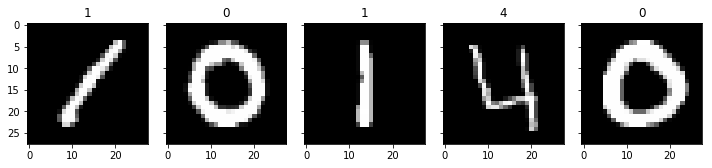

In [14]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[i].set_title(y[i])
plt.tight_layout()    

### Distribution of labels 
**(in train set)**

In [15]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

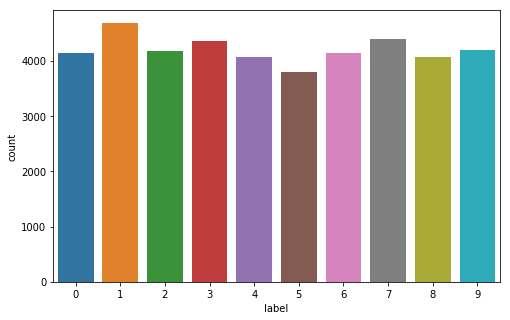

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.countplot(y)

### Check some images

**get indexes of first 10 occurences for each number**

In [17]:
li_idxs = []
for i in range(10):
    for nr in range(10):
        ix = y[y==nr].index[i]
        li_idxs.append(ix) 

### first 10 image samples for each digit

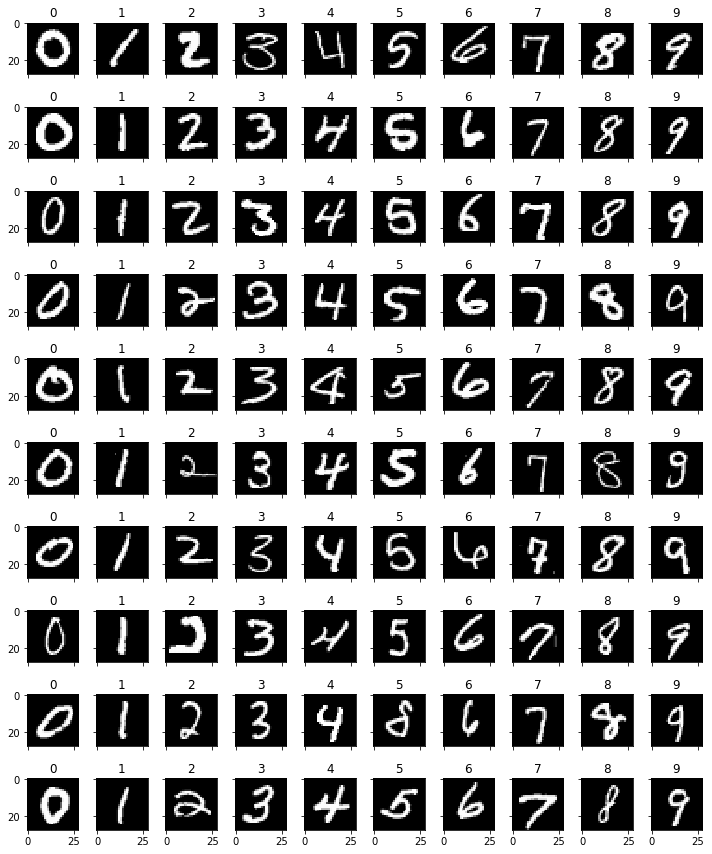

In [18]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for n, i in enumerate(li_idxs):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(y[i])
plt.tight_layout()    

### **Conclusions on EDA**

1. **We can see that there is a lot of variety in the look of the numbers**  
2. **The digits are obviously written by many different people**
3. **And it seems that there might be difficulties identifying some of the digits correctly also for humans:**




* The 6s in row 0 1 and 6 look close to a 4  
* The 5 in row 1 looks close to a 6 and the 5 in row 8 looks close to a 8  
* The 4 in row 4 is wriiten differently as the other 4s and the 4 in row 7 almost looks like a 7  
* The 8 in row 8 is wriiten differently as the other 8s  

# Part 2 : Sklearn Classifiers

### Perceptron

In [19]:
from sklearn.linear_model import Perceptron
clf_Perceptron = Perceptron(random_state=0)
param_grid = { 'penalty': ['l1','l2'], 'tol': [0.05, 0.1] }
GridCV_Perceptron = GridSearchCV(clf_Perceptron, param_grid, verbose=1, cv=5)
GridCV_Perceptron.fit(X_train,y_train)
score_grid_Perceptron = get_best_score(GridCV_Perceptron)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.9min finished


0.8588
{'penalty': 'l1', 'tol': 0.1}
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l1', random_state=0, shuffle=True, tol=0.1,
      validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
pred_val_perc = GridCV_Perceptron.predict(X_val)

In [21]:
acc_perc = print_validation_report(y_val, pred_val_perc)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       998
           1       0.92      0.95      0.94      1127
           2       0.81      0.88      0.85       967
           3       0.82      0.88      0.85      1060
           4       0.88      0.91      0.90       914
           5       0.92      0.70      0.79       914
           6       0.97      0.85      0.91       951
           7       0.94      0.86      0.90      1066
           8       0.81      0.84      0.82       995
           9       0.79      0.90      0.84      1008

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy : 0.8763


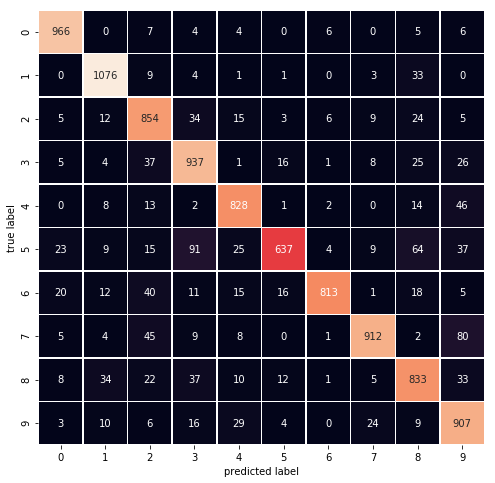

In [22]:
plot_confusion_matrix(y_val, pred_val_perc)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state=0)
param_grid = {'C': [0.014,0.012], 'multi_class': ['multinomial'],  
              'penalty': ['l1'],'solver': ['saga'], 'tol': [0.1] }
GridCV_LR = GridSearchCV(clf_LR, param_grid, verbose=1, cv=5)
GridCV_LR.fit(X_train,y_train)
score_grid_LR = get_best_score(GridCV_LR)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


0.8724
{'C': 0.014, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1}
LogisticRegression(C=0.014, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=0, solver='saga',
          tol=0.1, verbose=0, warm_start=False)


In [24]:
pred_val_lr = GridCV_LR.predict(X_val)
acc_lr = print_validation_report(y_val, pred_val_lr)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       998
           1       0.87      0.98      0.92      1127
           2       0.88      0.87      0.88       967
           3       0.87      0.84      0.86      1060
           4       0.86      0.90      0.88       914
           5       0.84      0.79      0.82       914
           6       0.90      0.92      0.91       951
           7       0.90      0.89      0.90      1066
           8       0.89      0.80      0.84       995
           9       0.84      0.83      0.83      1008

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy : 0.8785


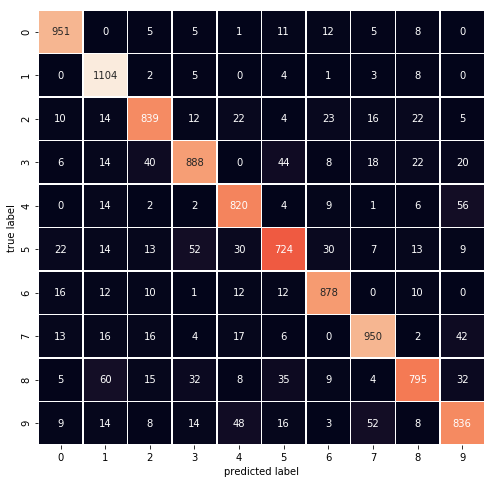

In [25]:
plot_confusion_matrix(y_val, pred_val_lr)

### KNN

Using GridSearchCV with KNN takes very long for this dataset.  
Therefore I fit the data with one parameter: neighbors = 10  
The resulting accuracy is already quite good.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [27]:
pred_val_knn = clf_knn.predict(X_val)
acc_knn = print_validation_report(y_val, pred_val_knn)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       998
           1       0.93      1.00      0.96      1127
           2       0.98      0.95      0.97       967
           3       0.97      0.96      0.97      1060
           4       0.98      0.96      0.97       914
           5       0.96      0.96      0.96       914
           6       0.97      0.99      0.98       951
           7       0.95      0.97      0.96      1066
           8       0.99      0.92      0.95       995
           9       0.95      0.94      0.94      1008

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9638


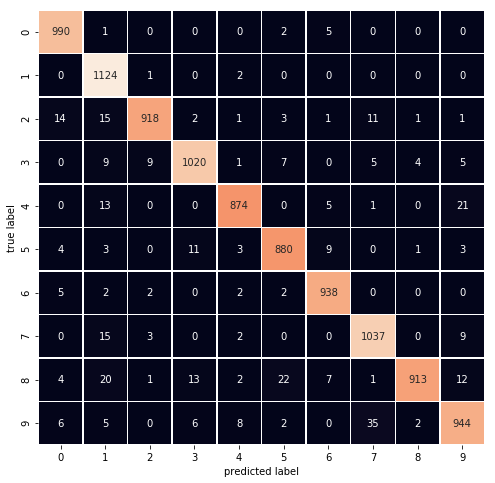

In [28]:
plot_confusion_matrix(y_val, pred_val_knn)

### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(random_state=0)
param_grid = {'max_depth': [15], 'max_features': [100],  
              'min_samples_split': [5],'n_estimators' : [50] }
GridCV_RF = GridSearchCV(clf_RF, param_grid, verbose=1, cv=5)
GridCV_RF.fit(X_train,y_train)
score_grid_RF = get_best_score(GridCV_RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


0.9543666666666667
{'max_depth': 15, 'max_features': 100, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


'RandomForestClassifier' object has no attribute 'loss_curve_'

In [30]:
pred_val_rf = GridCV_RF.predict(X_val)

In [31]:
acc_rf = print_validation_report(y_val, pred_val_rf)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.95      0.97      0.96       967
           3       0.96      0.93      0.94      1060
           4       0.96      0.96      0.96       914
           5       0.97      0.96      0.96       914
           6       0.97      0.97      0.97       951
           7       0.96      0.96      0.96      1066
           8       0.95      0.95      0.95       995
           9       0.93      0.93      0.93      1008

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9596


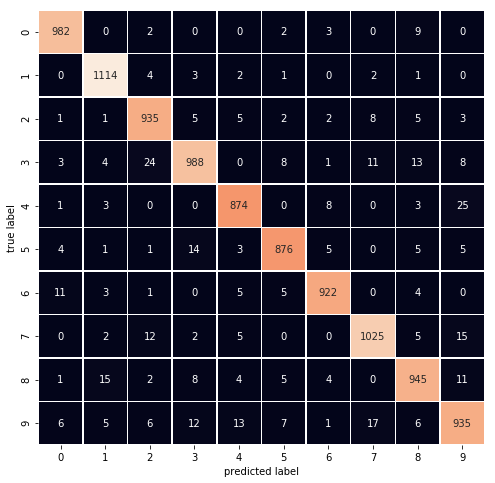

In [32]:
plot_confusion_matrix(y_val, pred_val_rf)

### Support Vector Machine Classifier

Like for KNN, GridSearchCV for SVM takes very long, so I only fit one good set of parameters here.

In [33]:
from sklearn.svm import SVC
clf_svm = SVC(C=5, gamma=0.05, kernel='rbf', random_state=0)
clf_svm.fit(X_train,y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
pred_val_svm = clf_svm.predict(X_val)
acc_svm = print_validation_report(y_val, pred_val_svm)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       998
           1       0.99      0.99      0.99      1127
           2       0.97      0.99      0.98       967
           3       0.98      0.97      0.98      1060
           4       0.98      0.97      0.98       914
           5       0.98      0.98      0.98       914
           6       0.99      0.99      0.99       951
           7       0.98      0.98      0.98      1066
           8       0.98      0.98      0.98       995
           9       0.98      0.96      0.97      1008

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy : 0.9808


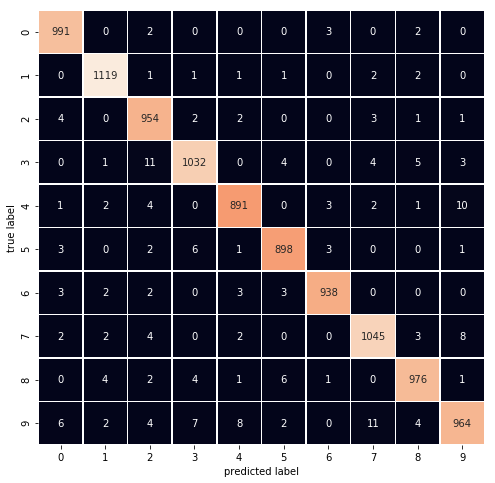

In [35]:
plot_confusion_matrix(y_val, pred_val_svm)

### Multi Layer Perceptron

In [36]:
batchsize = int(nr_samples/15) 

In [37]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(activation = "logistic", hidden_layer_sizes=(200,), random_state=0)
param_grid = { 'batch_size' : [batchsize] , 'max_iter': [600], 'alpha': [1e-4], 
               'solver': ['sgd'], 'learning_rate_init': [0.05,0.06],'tol': [1e-4] }
    
GridCV_MLP = GridSearchCV(clf_mlp, param_grid, verbose=1, cv=3)
GridCV_MLP.fit(X_train,y_train)
score_grid_MLP = get_best_score(GridCV_MLP)   

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.9min finished


0.9497
{'alpha': 0.0001, 'batch_size': 2000, 'learning_rate_init': 0.06, 'max_iter': 600, 'solver': 'sgd', 'tol': 0.0001}
MLPClassifier(activation='logistic', alpha=0.0001, batch_size=2000,
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.06, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


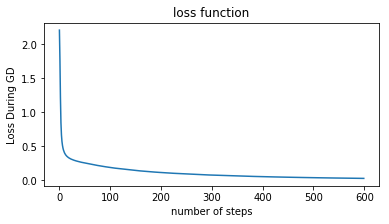

In [38]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(GridCV_MLP.best_estimator_.loss_curve_)

plt.xlabel("number of steps") 
plt.ylabel("Loss During GD")
plt.title("loss function")
plt.show()

In [39]:
pred_val_mlp = GridCV_MLP.predict(X_val)

In [40]:
acc_mlp = print_validation_report(y_val, pred_val_mlp)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       998
           1       0.98      0.99      0.98      1127
           2       0.98      0.97      0.98       967
           3       0.97      0.97      0.97      1060
           4       0.97      0.97      0.97       914
           5       0.97      0.96      0.97       914
           6       0.97      0.98      0.98       951
           7       0.97      0.97      0.97      1066
           8       0.97      0.97      0.97       995
           9       0.96      0.95      0.95      1008

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy : 0.9723


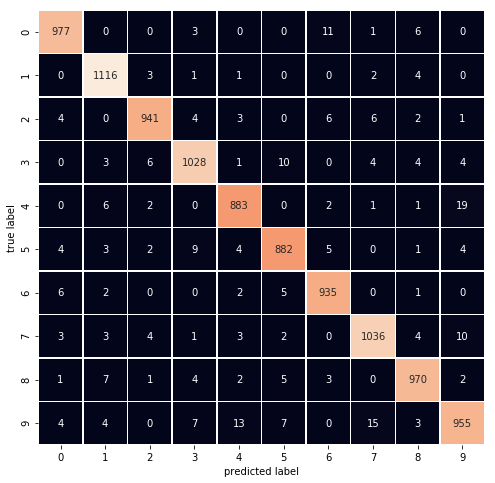

In [41]:
plot_confusion_matrix(y_val, pred_val_mlp)

# Part 3: NN Classifiers with Keras

In [42]:
y_train = to_categorical(y_train, 10)
y_val_10 = to_categorical(y_val, 10)

## 3.1 Fully-Connected Neural Networks  
dense layers : every node is connected to every other node in the next layer

### 3.1.1 Keras: only input and output layer

In [43]:
def dense_model_0():
    model = Sequential()
    model.add(Dense(10, input_dim=784, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
model_dense_0 = dense_model_0()
model_dense_0.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_dense_0.fit(X_train, y_train, epochs=50, batch_size=batchsize)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
30000/30000 [==============================] - 2s 80us/step - loss: 2.0498 - acc: 0.3164
Epoch 2/50
30000/30000 [==============================] - 2s 64us/step - loss: 1.5124 - acc: 0.6587
Epoch 3/50
30000/30000 [==============================] - 2s 63us/step - loss: 1.1711 - acc: 0.7565
Epoch 4/50
30000/30000 [==============================] - 2s 64us/step - loss: 0.9644 - acc: 0.7921
Epoch 5/50
30000/30000 [==============================] - 2s 64us/step - loss: 0.8339 - acc: 0.8187
Epoch 6/50
30000/30000 [==============================] - 2s 70us/step - loss: 0.7452 - acc: 0.8333
Epoch 7/50
30000/30000 [==============================] - 2s 71us/step - loss: 0.6808 - acc: 0.8451
Epoch 8/50
30000/30000 [==============================] - 2s 72us/step - loss: 0.6316 - acc: 0.8533
Epoch 9/50
30000/30000 [==============================] - 2s 71us/step - loss: 0.5928 - acc: 0.8611
Epoch 10/50
30000/30000 [===========================

In [46]:
pred_val_dense0 = model_dense_0.predict_classes(X_val)

In [47]:
acc_fc0 = print_validation_report(y_val, pred_val_dense0)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       998
           1       0.93      0.98      0.96      1127
           2       0.91      0.89      0.90       967
           3       0.90      0.90      0.90      1060
           4       0.91      0.93      0.92       914
           5       0.91      0.85      0.88       914
           6       0.93      0.95      0.94       951
           7       0.94      0.92      0.93      1066
           8       0.89      0.88      0.88       995
           9       0.88      0.90      0.89      1008

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy : 0.9161


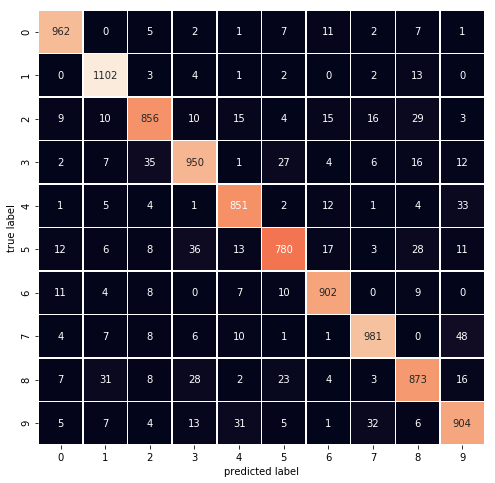

In [48]:
plot_confusion_matrix(y_val, pred_val_dense0)

### Keras: 1 hidden layer

In [49]:
def dense_model_1():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
model_dense_1 = dense_model_1()
model_dense_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_dense_1 = model_dense_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Train on 30000 samples, validate on 10000 samples
Epoch 1/50
30000/30000 [==============================] - 3s 93us/step - loss: 1.6440 - acc: 0.5457 - val_loss: 1.0121 - val_acc: 0.7648
Epoch 2/50
30000/30000 [==============================] - 2s 72us/step - loss: 0.7668 - acc: 0.8039 - val_loss: 0.5747 - val_acc: 0.8461
Epoch 3/50
30000/30000 [==============================] - 2s 72us/step - loss: 0.5023 - acc: 0.8640 - val_loss: 0.4326 - val_acc: 0.8800
Epoch 4/50
30000/30000 [==============================] - 2s 76us/step - loss: 0.4055 - acc: 0.8891 - val_loss: 0.3674 - val_acc: 0.8976
Epoch 5/50
30000/30000 [==============================] - 2s 77us/step - loss: 0.3550 - acc: 0.9025 - val_loss: 0.3319 - val_acc: 0.9092
Epoch 6/50
30000/30000 [==============================] - 2s 75us/step - loss: 0.3238 - acc: 0.9105 - val_loss: 0.3057 - val_acc: 0.9150
Epoch 7/50
30000/30000 [==============================] - 2s 75us/step - loss: 0.3001 - acc: 0.9168 - val_loss: 0.2871 - val_acc

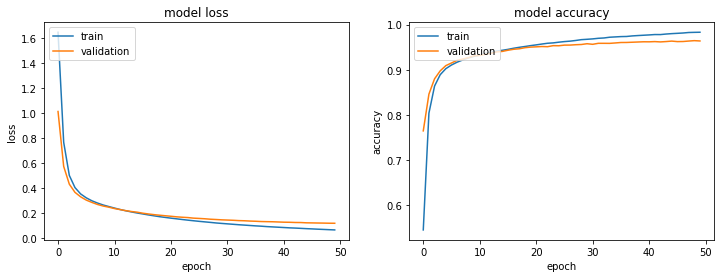

In [52]:
plot_history_loss_and_acc(history_dense_1)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.97      0.96      0.97       967
           3       0.97      0.95      0.96      1060
           4       0.96      0.95      0.95       914
           5       0.96      0.95      0.96       914
           6       0.96      0.98      0.97       951
           7       0.96      0.98      0.97      1066
           8       0.96      0.96      0.96       995
           9       0.94      0.93      0.94      1008

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

0.9637


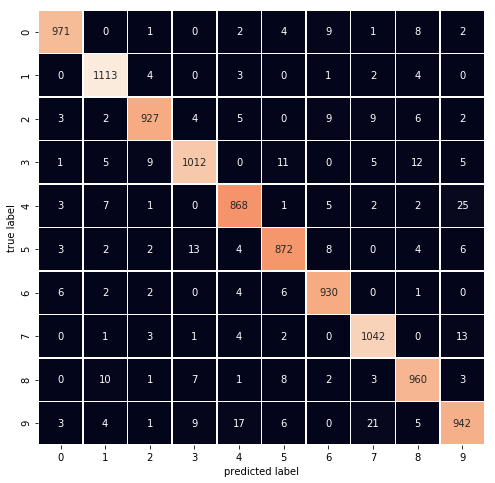

In [53]:
pred_val_dense1 = model_dense_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense1)
print(classification_report(y_val, pred_val_dense1))
acc_fc1 = accuracy_score(y_val, pred_val_dense1)
print(acc_fc1)

### Keras: 2 hidden layers

In [54]:
def dense_model_2():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [55]:
model_dense_2 = dense_model_2()
model_dense_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________


In [56]:
history_dense_2 = model_dense_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Train on 30000 samples, validate on 10000 samples
Epoch 1/50
30000/30000 [==============================] - 2s 82us/step - loss: 1.6775 - acc: 0.5866 - val_loss: 0.9096 - val_acc: 0.7960
Epoch 2/50
30000/30000 [==============================] - 2s 71us/step - loss: 0.6064 - acc: 0.8447 - val_loss: 0.4140 - val_acc: 0.8838
Epoch 3/50
30000/30000 [==============================] - 2s 71us/step - loss: 0.3739 - acc: 0.8925 - val_loss: 0.3162 - val_acc: 0.9094
Epoch 4/50
30000/30000 [==============================] - 2s 71us/step - loss: 0.3076 - acc: 0.9113 - val_loss: 0.2749 - val_acc: 0.9204
Epoch 5/50
30000/30000 [==============================] - 2s 73us/step - loss: 0.2691 - acc: 0.9217 - val_loss: 0.2514 - val_acc: 0.9270
Epoch 6/50
30000/30000 [==============================] - 2s 79us/step - loss: 0.2420 - acc: 0.9309 - val_loss: 0.2309 - val_acc: 0.9330
Epoch 7/50
30000/30000 [==============================] - 2s 77us/step - loss: 0.2228 - acc: 0.9361 - val_loss: 0.2183 - val_acc

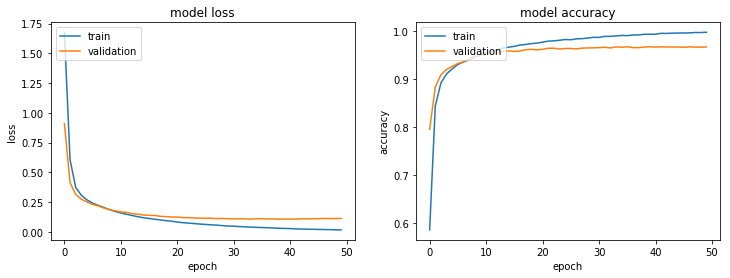

In [57]:
plot_history_loss_and_acc(history_dense_2)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.97      0.97      0.97       967
           3       0.96      0.96      0.96      1060
           4       0.96      0.97      0.96       914
           5       0.97      0.95      0.96       914
           6       0.96      0.98      0.97       951
           7       0.96      0.97      0.97      1066
           8       0.96      0.96      0.96       995
           9       0.96      0.92      0.94      1008

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.9672


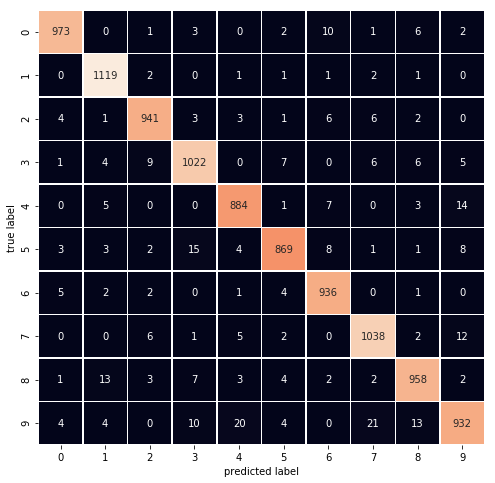

In [58]:
pred_val_dense2 = model_dense_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense2)
print(classification_report(y_val, pred_val_dense2))
acc_fc2 = accuracy_score(y_val, pred_val_dense2)
print(acc_fc2)

### Keras: 3 hidden layers

In [59]:
def dense_model_3():
    
    model = Sequential()  
    model.add(Dense(100, activation='relu', input_dim=784))
    model.add(Dense(200, activation='relu')) 
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(10, activation='softmax'))
         
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #model.compile(optimizer=RMSprop(lr=0.001),
    #         loss='categorical_crossentropy',
    #         metrics=['accuracy'])
    
    return model

In [60]:
model_dense_3 = dense_model_3()
model_dense_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 119,810
Trainable params: 119,810
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_dense_3 = model_dense_3.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Train on 30000 samples, validate on 10000 samples
Epoch 1/50
30000/30000 [==============================] - 3s 92us/step - loss: 1.7699 - acc: 0.5424 - val_loss: 0.9216 - val_acc: 0.7971
Epoch 2/50
30000/30000 [==============================] - 2s 79us/step - loss: 0.5783 - acc: 0.8445 - val_loss: 0.3789 - val_acc: 0.8854
Epoch 3/50
30000/30000 [==============================] - 2s 81us/step - loss: 0.3398 - acc: 0.8999 - val_loss: 0.2930 - val_acc: 0.9086
Epoch 4/50
30000/30000 [==============================] - 2s 80us/step - loss: 0.2705 - acc: 0.9213 - val_loss: 0.2416 - val_acc: 0.9268
Epoch 5/50
30000/30000 [==============================] - 2s 79us/step - loss: 0.2274 - acc: 0.9334 - val_loss: 0.2135 - val_acc: 0.9382
Epoch 6/50
30000/30000 [==============================] - 2s 78us/step - loss: 0.1984 - acc: 0.9420 - val_loss: 0.1921 - val_acc: 0.9421
Epoch 7/50
30000/30000 [==============================] - 2s 78us/step - loss: 0.1775 - acc: 0.9479 - val_loss: 0.1765 - val_acc

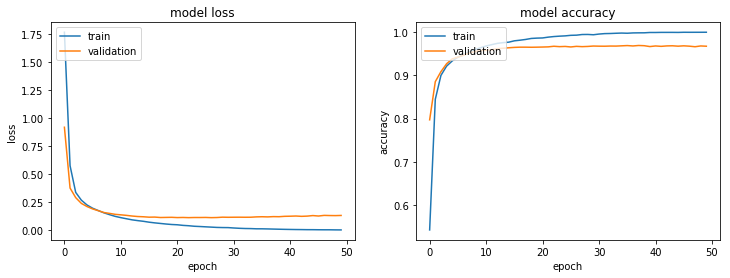

In [62]:
plot_history_loss_and_acc(history_dense_3)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       998
           1       0.98      0.99      0.99      1127
           2       0.97      0.97      0.97       967
           3       0.96      0.97      0.97      1060
           4       0.97      0.96      0.96       914
           5       0.95      0.96      0.96       914
           6       0.97      0.97      0.97       951
           7       0.97      0.97      0.97      1066
           8       0.96      0.96      0.96       995
           9       0.95      0.94      0.95      1008

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.9674


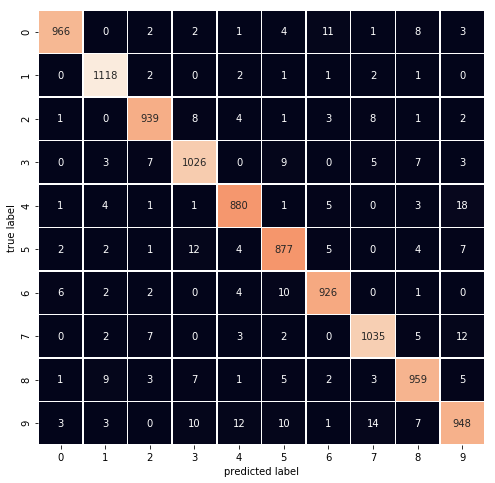

In [63]:
pred_val_dense3 = model_dense_3.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense3)
print(classification_report(y_val, pred_val_dense3))
acc_fc3 = accuracy_score(y_val, pred_val_dense3)
print(acc_fc3)

## 3.2 Keras : Convolutional Neural Networks, CNN

Convnets:  
[Udacity](https://www.youtube.com/watch?v=jajksuQW4mc) 

### **features : reshaping 1d vector to 2d images**

(784) --> (28,28,1)

In [64]:
X_train.shape

(30000, 784)

In [65]:
X_train = X_train.values.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.values.reshape(X_val.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [66]:
X_train.shape

(30000, 28, 28, 1)

In [67]:
y_train.shape

(30000, 10)

## Keras: CNN model 1
Conv2D (32, (3, 3))  
Conv2D (64, (3, 3))  
Pooling2D (2,2)  
Dropout (0.25)
Flatten  
Dense(128, relu)  
Dropout (0.5)  
Dense(10, softmax)

In [68]:
batchsize = 128
epochs = 12

In [69]:
activation = 'relu'
adadelta = Adadelta()
loss = categorical_crossentropy

In [70]:
def cnn_model_1(activation):
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape)) 
    
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())

    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=loss, optimizer=adadelta, metrics=['accuracy'])

    return model

In [71]:
model_cnn_1 = cnn_model_1(activation)
model_cnn_1.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1179776   
___________________________

In [72]:
#model_cnn_1.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, verbose=1)
history_cnn_1 = model_cnn_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                   epochs=epochs, batch_size=batchsize, verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/12
30000/30000 [==============================] - 66s 2ms/step - loss: 0.3890 - acc: 0.8781 - val_loss: 0.0921 - val_acc: 0.9718
Epoch 2/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.1205 - acc: 0.9635 - val_loss: 0.0568 - val_acc: 0.9827
Epoch 3/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.0867 - acc: 0.9732 - val_loss: 0.0479 - val_acc: 0.9847
Epoch 4/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.0694 - acc: 0.9790 - val_loss: 0.0529 - val_acc: 0.9843
Epoch 5/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.0574 - acc: 0.9828 - val_loss: 0.0438 - val_acc: 0.9868
Epoch 6/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.0505 - acc: 0.9837 - val_loss: 0.0397 - val_acc: 0.9884
Epoch 7/12
30000/30000 [==============================] - 62s 2ms/step - loss: 0.0461 - acc: 0.9860 - val_loss: 0.0356 - val_acc

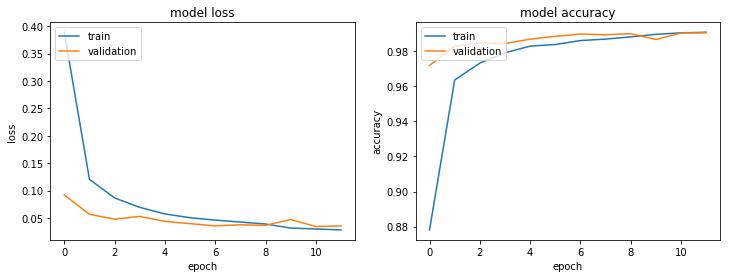

In [73]:
plot_history_loss_and_acc(history_cnn_1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       998
           1       0.99      1.00      1.00      1127
           2       0.98      0.99      0.99       967
           3       1.00      0.99      0.99      1060
           4       0.99      0.99      0.99       914
           5       0.99      0.99      0.99       914
           6       0.99      0.99      0.99       951
           7       0.99      0.99      0.99      1066
           8       0.99      0.99      0.99       995
           9       0.99      0.98      0.98      1008

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

0.9904


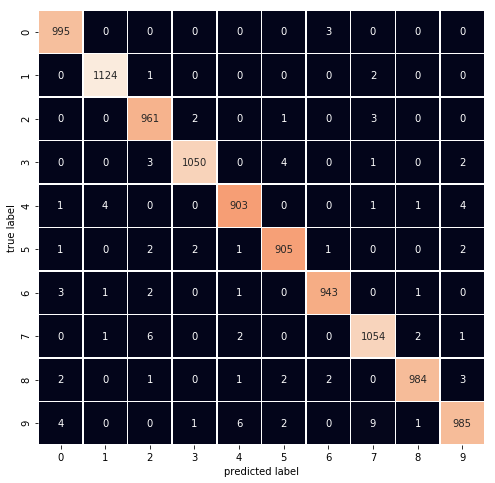

In [74]:
pred_val_cnn1 = model_cnn_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn1)
print(classification_report(y_val, pred_val_cnn1))
acc_cnn1 = accuracy_score(y_val, pred_val_cnn1)
print(acc_cnn1)


### Keras: CNN model 2  
Conv2D (32, (3, 3))  
Pooling2D (2,2)  
Conv2D (32, (3, 3))  
Pooling2D (2,2)  
Flatten  
Dense(256, relu)  
Dense(10, softmax)  

In [75]:
batch_size=90
epochs=30


In [76]:
def cnn_model_2(optimizer,loss):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'Same', activation="relu", input_shape=input_shape ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation=activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy']) 

    return model

In [77]:
model_cnn_2 = cnn_model_2(adadelta, categorical_crossentropy)
model_cnn_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               295168    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
Total para

In [78]:
#model_cnn_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
history_cnn_2 = model_cnn_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                epochs=epochs, batch_size=batchsize, verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/30
30000/30000 [==============================] - 19s 626us/step - loss: 0.3421 - acc: 0.8938 - val_loss: 0.1023 - val_acc: 0.9695
Epoch 2/30
30000/30000 [==============================] - 18s 611us/step - loss: 0.0838 - acc: 0.9738 - val_loss: 0.0667 - val_acc: 0.9786
Epoch 3/30
30000/30000 [==============================] - 19s 619us/step - loss: 0.0565 - acc: 0.9819 - val_loss: 0.0497 - val_acc: 0.9847
Epoch 4/30
30000/30000 [==============================] - 19s 622us/step - loss: 0.0414 - acc: 0.9858 - val_loss: 0.0501 - val_acc: 0.9833
Epoch 5/30
30000/30000 [==============================] - 19s 620us/step - loss: 0.0310 - acc: 0.9896 - val_loss: 0.0461 - val_acc: 0.9862
Epoch 6/30
30000/30000 [==============================] - 19s 617us/step - loss: 0.0237 - acc: 0.9926 - val_loss: 0.0481 - val_acc: 0.9862
Epoch 7/30
30000/30000 [==============================] - 18s 614us/step - loss: 0.0179 - acc: 0.9945 - val_loss: 0.

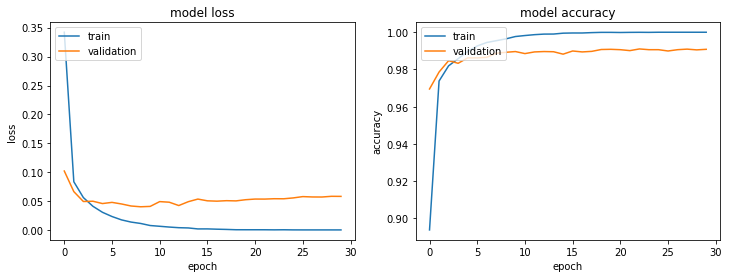

In [79]:
plot_history_loss_and_acc(history_cnn_2)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       998
           1       0.99      1.00      0.99      1127
           2       0.99      0.99      0.99       967
           3       0.99      0.99      0.99      1060
           4       0.99      0.99      0.99       914
           5       0.99      0.99      0.99       914
           6       1.00      1.00      1.00       951
           7       0.99      0.99      0.99      1066
           8       0.99      0.99      0.99       995
           9       0.99      0.97      0.98      1008

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

0.9908


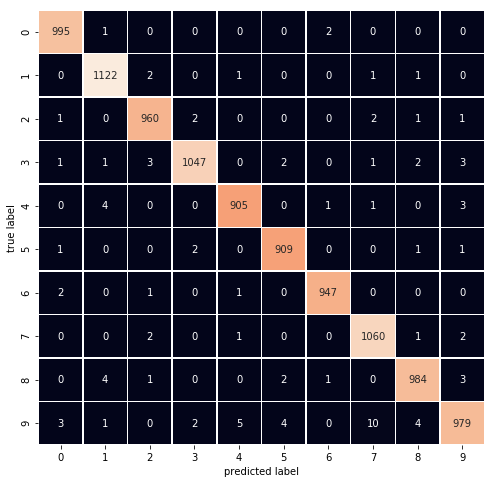

In [80]:
pred_val_cnn2 = model_cnn_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn2)
print(classification_report(y_val, pred_val_cnn2))
acc_cnn2 = accuracy_score(y_val, pred_val_cnn2)
print(acc_cnn2)

# Part 4: Predictions for test data

In [81]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
if mode == "edit" :
    X = X[:nr_samples//2]
    y = y[:nr_samples//2]
    X_test = X_test[:nr_samples//2]
    sample_submission = sample_submission[:nr_samples//2]

In [82]:
print(X.shape)
print(y.shape)
print(X_test.shape)

(42000, 784)
(42000,)
(28000, 784)


## Fitting on all training data

**For the GridSearchCV studies on finding the best model parameters we fit the classifiers using cross validation.**  
**This reduces the number of training examples because a portion of the data is used for validation.**  
**We now fit the classifiers on the complete training set (42000 samples).**  
**Then we use this new fit to make predictions for the test dataset (28000 samples).**

**Perceptron**

In [83]:
print(GridCV_Perceptron.best_params_)
GridCV_Perceptron.best_estimator_.fit(X,y)

{'penalty': 'l1', 'tol': 0.1}


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l1', random_state=0, shuffle=True, tol=0.1,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
pred_test_perc = GridCV_Perceptron.best_estimator_.predict(X_test)
result_perc = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_perc})
result_perc.to_csv("subm_perc.csv",index=False)

**Logistic Regression**

In [85]:
print(GridCV_LR.best_params_)
GridCV_LR.best_estimator_.fit(X,y)

{'C': 0.014, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1}


LogisticRegression(C=0.014, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=0, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

In [86]:
pred_test_lr = GridCV_LR.best_estimator_.predict(X_test)
result_lr = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_lr})
result_lr.to_csv("subm_lr.csv",index=False)

**KNN**

In [87]:
clf_knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [88]:
pred_test_knn = clf_knn.predict(X_test)
result_knn = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_knn})
result_knn.to_csv("subm_knn.csv",index=False)

**Random Forest**

In [89]:
print(GridCV_RF.best_params_)
GridCV_RF.best_estimator_.fit(X,y)

{'max_depth': 15, 'max_features': 100, 'min_samples_split': 5, 'n_estimators': 50}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [90]:
pred_test_rf = GridCV_RF.best_estimator_.predict(X_test)
result_rf = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_rf})
result_rf.to_csv("subm_rf.csv",index=False)

**SVM**

In [91]:
clf_svm.fit(X,y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
pred_test_svm = clf_svm.predict(X_test)
result_svm = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_svm})
result_svm.to_csv("subm_svm.csv",index=False)

**MLP**

In [93]:
print(GridCV_MLP.best_params_)
GridCV_MLP.best_estimator_.fit(X,y)

{'alpha': 0.0001, 'batch_size': 2000, 'learning_rate_init': 0.06, 'max_iter': 600, 'solver': 'sgd', 'tol': 0.0001}


MLPClassifier(activation='logistic', alpha=0.0001, batch_size=2000,
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.06, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [94]:
pred_test_mlp = GridCV_MLP.best_estimator_.predict(X_test)
result_mlp = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_mlp})
result_mlp.to_csv("subm_mlp.csv",index=False)

In [95]:
y = to_categorical(y, 10)

**dense_1**

In [96]:
model_dense_1.fit(X,y)
pred_test_fc1 = model_dense_1.predict_classes(X_test)
result_fc1 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc1})
result_fc1.to_csv("dense_1.csv",index=False)

Epoch 1/1
42000/42000 [==============================] - 6s 143us/step - loss: 0.1162 - acc: 0.9640


**dense_2**

In [97]:
model_dense_2.fit(X,y)
pred_test_fc2 = model_dense_2.predict_classes(X_test)
result_fc2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc2})
result_fc2.to_csv("dense_2.csv",index=False)

Epoch 1/1
42000/42000 [==============================] - 6s 150us/step - loss: 0.1173 - acc: 0.9630


**dense_3**

In [98]:
model_dense_3.fit(X,y)
pred_test_fc3 = model_dense_3.predict_classes(X_test)
result_fc3 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc3})
result_fc3.to_csv("dense_3.csv",index=False)

Epoch 1/1
42000/42000 [==============================] - 7s 155us/step - loss: 0.1325 - acc: 0.9611


**reshape for CNN**

In [99]:
X = X.values.reshape(X.shape[0], img_rows, img_cols, 1)
X_test = X_test.values.reshape(X_test.shape[0], img_rows, img_cols, 1)
#y = to_categorical(y, 10)

**CNN 1**

In [100]:
batchsize = 128
epochs = 12
model_cnn_1 = cnn_model_1('relu')
model_cnn_1.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)

In [101]:
pred_test_cnn_1 = model_cnn_1.predict(X_test)
pred_test_cnn_1 = np.argmax(pred_test_cnn_1,axis=1)
result_cnn_1 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_1})
result_cnn_1.to_csv("subm_cnn_1.csv",index=False)

**CNN 2**

In [102]:
batch_size=90
epochs=30
model_cnn_2 = cnn_model_2(adadelta, categorical_crossentropy)
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)

In [103]:
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_adadelta.csv",index=False)

# Part 5: Comparing classifier performance

In [104]:
list_classifiers = ['PERC','LR','KNN','RF','SVM',
                    'MLP','DENSE1','DENSE2','DENSE3',
                    'CNN1','CNN2']

## Validation scores

from validation data

In [105]:
val_scores = [acc_perc, acc_lr, acc_knn, acc_rf, 
               acc_svm, acc_mlp, acc_fc1, acc_fc2, 
               acc_fc3, acc_cnn1, acc_cnn2]

## Test scores

from submission 

In [106]:
score_perc  = 0.88057
score_lr    = 0.88700
score_knn   = 0.96557
score_rf    = 0.96028
score_svm   = 0.98100
score_mlp   = 0.96985

score_dns_1  = 0.95971 
score_dns_2  = 0.96228      
score_dns_3  = 0.96128
score_cnn_1  = 0.98928
score_cnn_2  = 0.99028

In [107]:
test_scores = [score_perc, score_lr, score_knn, score_rf, score_svm, score_mlp,
               score_dns_1, score_dns_2, score_dns_3, score_cnn_1, score_cnn_2]

In [108]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)
trace2 = go.Scatter(x = list_classifiers, y = test_scores,
                   name="Submission", text = list_classifiers)

data = [trace1, trace2]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

## Conclusions on classifier performance

* Best accuracy around 99% is obtained with CNN1 and CNN2.  
* SVC also has very good accuracy with 98%  
* Except for Perceptron and Logistic regression, all classifiers get accuarcy similar to humans (above 95%)  
* Fully connected NNs (dense 1,2,3) show most overfitting (validation score much larger than test score)

# Part 6: Different Optimizers

Adadelta

In [109]:
model_cnn_2.optimizer

RMSprop

In [110]:
model_cnn_2_rmsprop = cnn_model_2(RMSprop(), categorical_crossentropy)
model_cnn_2_rmsprop.optimizer

In [111]:
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_rmsprop.csv",index=False)

Adam

In [112]:
model_cnn_2_adam = cnn_model_2(Adam(), categorical_crossentropy)
model_cnn_2_adam.optimizer

In [113]:
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_adam.csv",index=False)